<a href="https://colab.research.google.com/github/KillerStrike17/EVA-5/blob/master/11.%20Super%20Convergence/One_Cycle_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Oct 11 11:07:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/KillerStrike17/PyDeNN.git


Cloning into 'PyDeNN'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (313/313), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 313 (delta 106), reused 260 (delta 60), pack-reused 0
Receiving objects: 100% (313/313), 18.89 MiB | 6.61 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [1]:
%cd PyDeNN/

/content/PyDeNN


In [2]:
from DeNN.custom_model import david_net
from DeNN.dataset_loader import data_loader, data_augmentation
from DeNN.trainer import trainer
from DeNN.visualization import * 
from DeNN.util import *

In [3]:
import torch,torchvision
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import normalize, resize, to_tensor, to_pil_image
from torch.optim.lr_scheduler import ReduceLROnPlateau,OneCycleLR

In [4]:
DATA_PATH = 'data/'
BATCH_SIZE =128

In [5]:
  my_transformations = data_augmentation.DataAugmentationCifar10_album()
  train, test = data_loader.DatasetCifar10(data_path = DATA_PATH,transformations = my_transformations,batch_size = BATCH_SIZE).load_data()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = david_net.David_net().to(device)
summary(model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
     Resnet_block-14          [-1, 128,

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.76E-01



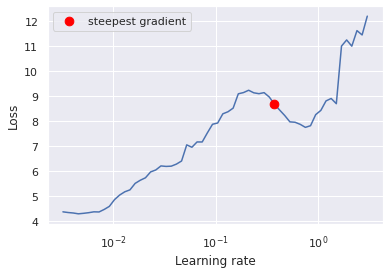

In [9]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train, end_lr=100, num_iter=100)
my_plt,lr_val = lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [10]:
lr_val = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]

In [11]:
max_lr = lr_val
min_lr = max_lr/10
max_lr,min_lr

(0.004534878508128583, 0.00045348785081285824)

In [13]:

scheduler = OneCycleLR(optimizer,max_lr=max_lr,steps_per_epoch=len(train),epochs = 24,pct_start=4/24)

In [14]:
# optimizer = optim.SGD(model.parameters(), lr=lr_val, momentum=0.9)
trainer = trainer.Trainer( model =model , optimizer =optimizer , device =device , train_loader = train, test_loader = test,epochs = 24,criteria = criterion,scheduler = scheduler)

In [15]:
(w,x),(y,z) = trainer.train()

loss=5.10180139541626 batch_id=0 Accuracy = 0.00024:   0%|          | 1/391 [00:00<00:48,  8.11it/s]

Epoch: 1
LR Value 0.000181395140325143


loss=1.685442328453064 batch_id=390 Accuracy = 0.44416: 100%|██████████| 391/391 [00:42<00:00,  9.12it/s]
loss=1.2898147106170654 batch_id=0 Accuracy = 0.00144:   0%|          | 1/391 [00:00<00:45,  8.54it/s]


Test set: Average loss: 0.0128, Accuracy: 4745/10000 (47.45%)

Epoch: 2
LR Value 0.0008197216461191931


loss=1.034536361694336 batch_id=390 Accuracy = 0.57906: 100%|██████████| 391/391 [00:42<00:00,  9.18it/s]
loss=1.4211533069610596 batch_id=0 Accuracy = 0.00144:   0%|          | 1/391 [00:00<00:41,  9.47it/s]


Test set: Average loss: 0.0110, Accuracy: 5876/10000 (58.76%)

Epoch: 3
LR Value 0.0023603244232453433


loss=1.0823028087615967 batch_id=390 Accuracy = 0.6556: 100%|██████████| 391/391 [00:42<00:00,  9.15it/s]
loss=1.0639723539352417 batch_id=0 Accuracy = 0.00166:   0%|          | 1/391 [00:00<00:45,  8.60it/s]


Test set: Average loss: 0.0080, Accuracy: 6743/10000 (67.43%)

Epoch: 4
LR Value 0.0038996441795630323


loss=0.9347880482673645 batch_id=390 Accuracy = 0.72162: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]
loss=0.6923811435699463 batch_id=0 Accuracy = 0.00196:   0%|          | 1/391 [00:00<00:43,  8.86it/s]


Test set: Average loss: 0.0079, Accuracy: 6923/10000 (69.23%)

Epoch: 5
LR Value 0.004534878325154254


loss=0.6117294430732727 batch_id=390 Accuracy = 0.76162: 100%|██████████| 391/391 [00:42<00:00,  9.18it/s]
loss=0.49595358967781067 batch_id=0 Accuracy = 0.0022:   0%|          | 1/391 [00:00<00:42,  9.12it/s]


Test set: Average loss: 0.0058, Accuracy: 7671/10000 (76.71%)

Epoch: 6
LR Value 0.004506820001022455


loss=0.4842451214790344 batch_id=390 Accuracy = 0.78492: 100%|██████████| 391/391 [00:42<00:00,  9.19it/s]
loss=0.5703611969947815 batch_id=0 Accuracy = 0.00206:   0%|          | 1/391 [00:00<00:46,  8.39it/s]


Test set: Average loss: 0.0052, Accuracy: 7896/10000 (78.96%)

Epoch: 7
LR Value 0.004423620914149465


loss=0.7343811392784119 batch_id=390 Accuracy = 0.81032: 100%|██████████| 391/391 [00:42<00:00,  9.12it/s]
loss=0.4370073080062866 batch_id=0 Accuracy = 0.0021:   0%|          | 1/391 [00:00<00:42,  9.16it/s]


Test set: Average loss: 0.0049, Accuracy: 8092/10000 (80.92%)

Epoch: 8
LR Value 0.004287329702176035


loss=0.5647792220115662 batch_id=390 Accuracy = 0.82572: 100%|██████████| 391/391 [00:42<00:00,  9.21it/s]
loss=0.35158511996269226 batch_id=0 Accuracy = 0.0023:   0%|          | 1/391 [00:00<00:40,  9.70it/s]


Test set: Average loss: 0.0042, Accuracy: 8324/10000 (83.24%)

Epoch: 9
LR Value 0.0041013023070655494


loss=0.4683663249015808 batch_id=390 Accuracy = 0.83832: 100%|██████████| 391/391 [00:42<00:00,  9.19it/s]
loss=0.4941767156124115 batch_id=0 Accuracy = 0.00222:   0%|          | 1/391 [00:00<00:44,  8.75it/s]


Test set: Average loss: 0.0043, Accuracy: 8273/10000 (82.73%)

Epoch: 10
LR Value 0.0038701193406751586


loss=0.33711346983909607 batch_id=390 Accuracy = 0.85454: 100%|██████████| 391/391 [00:42<00:00,  9.14it/s]
loss=0.333106130361557 batch_id=0 Accuracy = 0.00228:   0%|          | 1/391 [00:00<00:42,  9.12it/s]


Test set: Average loss: 0.0044, Accuracy: 8264/10000 (82.64%)

Epoch: 11
LR Value 0.0035994732948896706


loss=0.37875738739967346 batch_id=390 Accuracy = 0.86746: 100%|██████████| 391/391 [00:42<00:00,  9.16it/s]
loss=0.3518259525299072 batch_id=0 Accuracy = 0.0022:   0%|          | 1/391 [00:00<00:44,  8.71it/s]


Test set: Average loss: 0.0034, Accuracy: 8632/10000 (86.32%)

Epoch: 12
LR Value 0.0032960283735790513


loss=0.23949864506721497 batch_id=390 Accuracy = 0.8751: 100%|██████████| 391/391 [00:42<00:00,  9.19it/s]
loss=0.36179661750793457 batch_id=0 Accuracy = 0.00224:   0%|          | 1/391 [00:00<00:41,  9.36it/s]


Test set: Average loss: 0.0033, Accuracy: 8700/10000 (87.00%)

Epoch: 13
LR Value 0.002967256397781925


loss=0.34502550959587097 batch_id=390 Accuracy = 0.89004: 100%|██████████| 391/391 [00:42<00:00,  9.19it/s]
loss=0.32287102937698364 batch_id=0 Accuracy = 0.00226:   0%|          | 1/391 [00:00<00:44,  8.78it/s]


Test set: Average loss: 0.0033, Accuracy: 8680/10000 (86.80%)

Epoch: 14
LR Value 0.0026212528246740475


loss=0.4143213629722595 batch_id=390 Accuracy = 0.89798: 100%|██████████| 391/391 [00:42<00:00,  9.14it/s]
loss=0.22693738341331482 batch_id=0 Accuracy = 0.00236:   0%|          | 1/391 [00:00<00:45,  8.64it/s]


Test set: Average loss: 0.0035, Accuracy: 8629/10000 (86.29%)

Epoch: 15
LR Value 0.0022665374105453563


loss=0.18004266917705536 batch_id=390 Accuracy = 0.9061: 100%|██████████| 391/391 [00:42<00:00,  9.17it/s]
loss=0.1323409229516983 batch_id=0 Accuracy = 0.00242:   0%|          | 1/391 [00:00<00:41,  9.49it/s]


Test set: Average loss: 0.0030, Accuracy: 8802/10000 (88.02%)

Epoch: 16
LR Value 0.0019118444261246683


loss=0.40657106041908264 batch_id=390 Accuracy = 0.9163: 100%|██████████| 391/391 [00:42<00:00,  9.16it/s]
loss=0.2519798278808594 batch_id=0 Accuracy = 0.0024:   0%|          | 1/391 [00:00<00:40,  9.57it/s]


Test set: Average loss: 0.0029, Accuracy: 8846/10000 (88.46%)

Epoch: 17
LR Value 0.0015659075898469444


loss=0.2506858706474304 batch_id=390 Accuracy = 0.92634: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
loss=0.2286343276500702 batch_id=0 Accuracy = 0.00238:   0%|          | 1/391 [00:00<00:44,  8.83it/s]


Test set: Average loss: 0.0030, Accuracy: 8840/10000 (88.40%)

Epoch: 18
LR Value 0.0012372450147198793


loss=0.13272158801555634 batch_id=390 Accuracy = 0.932: 100%|██████████| 391/391 [00:42<00:00,  9.10it/s]
loss=0.16245238482952118 batch_id=0 Accuracy = 0.0024:   0%|          | 1/391 [00:00<00:42,  9.18it/s]


Test set: Average loss: 0.0028, Accuracy: 8928/10000 (89.28%)

Epoch: 19
LR Value 0.0009339494641116532


loss=0.19330085813999176 batch_id=390 Accuracy = 0.94026: 100%|██████████| 391/391 [00:42<00:00,  9.14it/s]
loss=0.15668533742427826 batch_id=0 Accuracy = 0.00234:   0%|          | 1/391 [00:00<00:47,  8.13it/s]


Test set: Average loss: 0.0027, Accuracy: 8929/10000 (89.29%)

Epoch: 20
LR Value 0.000663489081058461


loss=0.2636151611804962 batch_id=390 Accuracy = 0.94832: 100%|██████████| 391/391 [00:42<00:00,  9.18it/s]
loss=0.20624709129333496 batch_id=0 Accuracy = 0.0024:   0%|          | 1/391 [00:00<00:41,  9.33it/s]


Test set: Average loss: 0.0027, Accuracy: 8974/10000 (89.74%)

Epoch: 21
LR Value 0.00043252349779762287


loss=0.07013143599033356 batch_id=390 Accuracy = 0.95514: 100%|██████████| 391/391 [00:42<00:00,  9.18it/s]
loss=0.08857513964176178 batch_id=0 Accuracy = 0.00246:   0%|          | 1/391 [00:00<00:41,  9.36it/s]


Test set: Average loss: 0.0026, Accuracy: 8998/10000 (89.98%)

Epoch: 22
LR Value 0.00024673985351984426


loss=0.1277579665184021 batch_id=390 Accuracy = 0.95816: 100%|██████████| 391/391 [00:42<00:00,  9.22it/s]
loss=0.14760276675224304 batch_id=0 Accuracy = 0.0024:   0%|          | 1/391 [00:00<00:44,  8.76it/s]


Test set: Average loss: 0.0025, Accuracy: 9026/10000 (90.26%)

Epoch: 23
LR Value 0.00011071275812780894


loss=0.07563904672861099 batch_id=390 Accuracy = 0.96128: 100%|██████████| 391/391 [00:42<00:00,  9.18it/s]
loss=0.09070681035518646 batch_id=0 Accuracy = 0.00246:   0%|          | 1/391 [00:00<00:45,  8.50it/s]


Test set: Average loss: 0.0025, Accuracy: 9018/10000 (90.18%)

Epoch: 24
LR Value 2.7791650158117036e-05


loss=0.07668308913707733 batch_id=390 Accuracy = 0.9616: 100%|██████████| 391/391 [00:42<00:00,  9.22it/s]



Test set: Average loss: 0.0025, Accuracy: 9016/10000 (90.16%)

